# Image decompression and azimuthal integration on the GPU

This tutorial explains how it is possible to speed-up azimuthal integration by speeding-up the critical part: the data transfer to the GPU.

For this tutorial, a very recent version of `silx` is needed, newer than fall'22 (available in release 1.2)

**Credits:**

* Thomas Vincent (ESRF) for the HDF5 direct chunk read and the Jupyter-slurm
* Jon Wright (ESRF) for the initial prototype of the bitshuffle-LZ4 decompression on the GPU
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs

**Nota:** a (fast) GPU is needed for this tutorial with OpenCL properly setup !

The example taken here is the same as the multithreading example: 4096 frames of Eiger_4M

In [1]:
%matplotlib inline

In [2]:
import sys, os, collections, struct, time
import numpy, pyFAI
import h5py, hdf5plugin
from matplotlib.pyplot import subplots
import bitshuffle
import pyopencl.array as cla
import silx
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
start_time = time.time()
ocl

OpenCL devices:
[0] Intel Gen OCL Driver: (0,0) Intel(R) HD Graphics Haswell Ultrabook GT3 reserved
[1] Intel(R) OpenCL: (1,0) Intel(R) Core(TM) i5-4308U CPU @ 2.80GHz

In [3]:
#Here we select the OpenCL device
target = (1,0)

## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [4]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.config

HDF5PluginBuildOptions(openmp=False, native=False, sse2=True, avx2=False, cpp11=True, filter_file_extension='.so', embedded_filters=('blosc', 'bshuf', 'fcidecomp', 'lz4', 'zfp', 'zstd'))

In [5]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 930.223


In [6]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [7]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

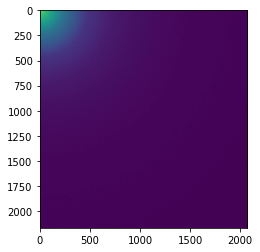

In [8]:
# display the image
fig,ax = subplots()
ax.imshow(frame)

In [9]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU")
print(f"Using algorithm {algo:10s}:", end=" ")
%timeit ai.integrate1d(img, nbins, method=("full", algo, "opencl", target))

Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU
Using algorithm histogram : 810 ms ± 9.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 70.5 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 52.4 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU
Using algorithm csr       : 

/home/kieffer/.venv/py39/lib/python3.9/site-packages/pyopencl/__init__.py:270: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i5-4308U CPU @ 2.80GHz' on 'Intel(R) OpenCL' at 0x2c54188> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <s8_to_float> was successfully vectorized (8)
Kernel <u8_to_float> was successfully vectorized (8)
Kernel <s16_to_float> was successfully vectorized (8)
Kernel <u16_to_float> was successfully vectorized (8)
Kernel <u32_to_float> was successfully vectorized (8)
Kernel <s32_to_float> was successfully vectorized (8)
Kernel <corrections> was not vectorized
Kernel <corrections2> was not vectorized
Kernel <corrections3> was not vectorized
Kernel <corrections4> was not vectorized
Kernel <memset_out> was successfully vectorized (8)
Kernel <memset_ng> was not vectorized
Kernel <memset1> was s

74.1 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

On this computer the CSR implementation in OpenMP looks like the fastest, regardless if it is executed on the CPU or on the iGPU.

In [10]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 1min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [11]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.242 GB with a compression ratio of 7.406x
Write speed: 843.219 MB/s of uncompressed data, or 46.995 fps.


In [12]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 54.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [13]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data, or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 1338.118 MB/s of uncompressed data, or 74.577 fps.


In [14]:
# Time for decompressing one frame:
chunk = bitshuffle.compress_lz4(frame,0)
print(f"Compression ratio: {frame.nbytes/len(chunk):.3f}x")
timing_decompress = %timeit -o bitshuffle.decompress_lz4(chunk, frame.shape, frame.dtype, 0)
print(f"Decompression speed: {1/timing_decompress.best:.3f} fps")

Compression ratio: 9.095x
12.4 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Decompression speed: 81.779 fps


In [15]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 3.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [16]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps.")

Read speed: 2836.805 MB/s of compressed data.
HDF5 read speed (without decompression): 1170.860 fps.


## Prepare the azimuthal integrator
To unleash the full performances of the azimuthal integrator, here the ability to deal with GPU arrays, one needs to extract the OpenCL integrator from AzimuthalIntegator. The integrator used here is a sparse matrix multiplication one with a CSR representation, tuned to run on the GPU.

In [17]:
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
#This is how the engine works. First send the image on the GPU:

frame_d = cla.to_device(engine.queue, frame)
omega_crc = engine.on_device["solidangle"]

res1 = engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
timing_integration = %timeit -r3 -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print(f"The maximum achievable integration speed on this device is {1/timing_integration.best:.3f} fps.")
timimg_sum = timing_integration.best + timing_read2.best/nbframes+timing_decompress.best
print(f"The maximum throughput considering reading, decompression and integration is {1/timimg_sum:.3f} fps.")

74.5 ms ± 1.01 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
The maximum achievable integration speed on this device is 13.635 fps.
The maximum throughput considering reading, decompression and integration is 11.571 fps.


**Summary:**
* Read speed: 1040 fps
* Read + decompress: 70 fps
* Read + decomperss + integrate: 10 fps.

## Using the decompression on the GPU

This feature requires silx 1.2 !

In [18]:
silx.version

'1.2.0-a0'

In [ ]:
gpu_decompressor = BitshuffleLz4(len(chunk), frame.nbytes, dtype=frame.dtype, ctx=engine.ctx, block_size=128)
for i in range(4, 10):
    j = 1<<i
    print(i,j, end=" ")
    %time  gpu_decompressor.decompress(chunk, wg=j)

# %time  gpu_decompressor.decompress(chunk)
gpu = gpu_decompressor.decompress(chunk).get()
#== frame.ravel())
gpu

In [ ]:
#Build a pipeline with decompression and integration on the GPU:
engine.integrate_ng(gpu_decomblock_size=essor(chunk,wg=128), solidangle=omega, solidangle_checksum=omega_crc)